## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [19]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [20]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [21]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [22]:
print(len(fmnist_dataset_train))
print(len(fmnist_dataset_test))

60000
10000


torch.Size([128, 1, 28, 28])
torch.Size([128])
128


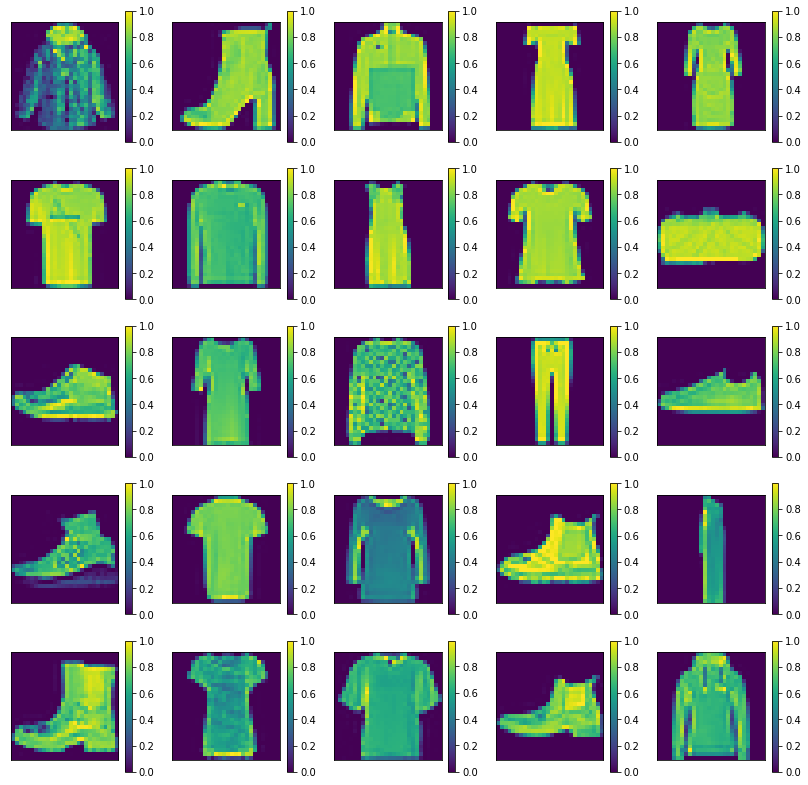

In [23]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    plt.rcParams['figure.figsize'] = [14, 14]
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img[i].reshape((28,28)))
        plt.colorbar()
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [24]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [25]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─BatchNorm1d: 2-2                  [-1, 784]                 1,568
|    └─Linear: 2-3                       [-1, 128]                 100,480
|    └─ReLU: 2-4                         [-1, 128]                 --
|    └─Linear: 2-5                       [-1, 64]                  8,256
|    └─Tanh: 2-6                         [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 10]                  650
Total params: 110,954
Trainable params: 110,954
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─BatchNorm1d: 2-2                  [-1, 784]                 1,568
|    └─Linear: 2-3                       [-1, 128]                 100,480
|    └─ReLU: 2-4                         [-1, 128]                 --
|    └─Linear: 2-5                       [-1, 64]                  8,256
|    └─Tanh: 2-6                         [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 10]                  650
Total params: 110,954
Trainable params: 110,954
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43

Your experiments come here:

In [26]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
i = 0
losses = []
accuracy = 0
for epoch in range(8):
    for img, label in train_loader:
        opt.zero_grad()
        img = img.to(device)
        label = label.to(device)
        out = model(img)
        loss = loss_func(out, label)
        loss.backward()
        opt.step()
        i+=1
        losses.append(loss.item())
        if i % 100 == 0:
            accuracy = 0
            for img, label in test_loader:
                img = img.to(device)
                label = label.to(device)
                out = model(img)
                accuracy += (torch.argmax(out, dim=1) == label).sum().item()
            accuracy /= len(fmnist_dataset_test)
            print('Epoch: ', epoch, 'Iteration: ', i, 'Loss: ', loss.item(), 'Accuracy: ', accuracy)

Epoch:  0 Iteration:  100 Loss:  0.5164082050323486 Accuracy:  0.8123
Epoch:  0 Iteration:  200 Loss:  0.3249891400337219 Accuracy:  0.838
Epoch:  0 Iteration:  300 Loss:  0.26405707001686096 Accuracy:  0.8459
Epoch:  0 Iteration:  400 Loss:  0.5984018445014954 Accuracy:  0.835
Epoch:  1 Iteration:  500 Loss:  0.38179248571395874 Accuracy:  0.8525
Epoch:  1 Iteration:  600 Loss:  0.39141637086868286 Accuracy:  0.8562
Epoch:  1 Iteration:  700 Loss:  0.3978721797466278 Accuracy:  0.853
Epoch:  1 Iteration:  800 Loss:  0.2860514521598816 Accuracy:  0.865
Epoch:  1 Iteration:  900 Loss:  0.2769613265991211 Accuracy:  0.8621
Epoch:  2 Iteration:  1000 Loss:  0.2951183319091797 Accuracy:  0.8607
Epoch:  2 Iteration:  1100 Loss:  0.22728750109672546 Accuracy:  0.8683
Epoch:  2 Iteration:  1200 Loss:  0.20556966960430145 Accuracy:  0.8744
Epoch:  2 Iteration:  1300 Loss:  0.36918705701828003 Accuracy:  0.8669
Epoch:  2 Iteration:  1400 Loss:  0.3615935742855072 Accuracy:  0.8709
Epoch:  3 Ite

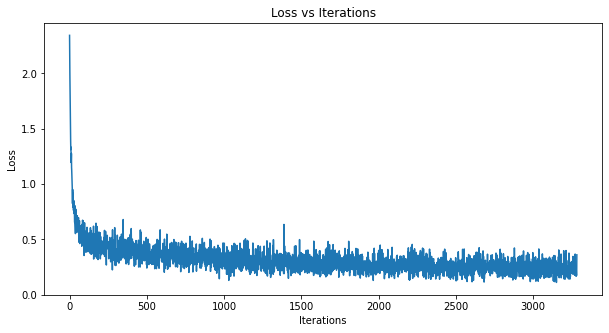

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()


In [28]:
with torch.no_grad():
    acum = 0
    for img, label in test_loader:
        img = img.to(device)
        out = model(img)
        out = torch.argmax(out, dim=1)
        label = label.to(device)
        accuracy = (out == label).sum().item() / label.size(0)
        acum += accuracy
    print('Average accuracy:', acum / len(test_loader))

Average accuracy: 0.88447265625


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [29]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        

In [30]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 128]                 100,480
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 64]                  8,256
|    └─Tanh: 2-5                         [-1, 64]                  --
|    └─Linear: 2-6                       [-1, 10]                  650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 128]                 100,480
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 64]                  8,256
|    └─Tanh: 2-5                         [-1, 64]                  --
|    └─Linear: 2-6                       [-1, 10]                  650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42

In [31]:
def train(model, train_loader, test_loader, loss_func, opt, epochs=10):
    i = 0
    losses_train = []
    losses_test = []
    iterations = []
    accuracies_train = []
    accuracies_test = []

    for epoch in range(epochs):
        acum_train = 0
        for size, (img, label) in enumerate(train_loader):
            opt.zero_grad()
            img = img.to(device)
            label = label.to(device)

            out = model(img)
            loss = loss_func(out, label)
            loss.backward()
            opt.step()

            i += 1
            accuracy_train = (torch.argmax(out, dim=1) == label).sum().item() / label.size(0)
            acum_train += accuracy_train
            losses_train.append(loss.item())

            if i%100 == 0:
                acum_test = 0
                for img, label in test_loader:
                    img = img.to(device)
                    label = label.to(device)
                    out = model(img)

                    loss_test = loss_func(out, label)
                    label = label.to(device)
                    out = torch.argmax(out, dim=1)
                    accuracy_test = (out == label).sum().item() / label.size(0)
                    acum_test += accuracy_test
                    
                iterations.append(i)
                losses_test.append(loss_test.item())
                accuracies_train.append(acum_train / (size + 1))
                accuracies_test.append(acum_test / len(test_loader))
                    
                if i % 400 == 0:
                    print('Epoch: ', epoch, 'Iteration: ', i, 'Loss: ', loss.item(), 'Accuracy train: ', acum_train / (size + 1), 'Accuracy test: ', acum_test / len(test_loader))
                if acum_train / (size + 1) > 0.92:
                    return iterations, losses_train, losses_test, accuracies_train, accuracies_test
    return iterations, losses_train, losses_test, accuracies_train, accuracies_test


In [32]:
import random
fmnist_dataset_train_overfit = torch.utils.data.Subset(fmnist_dataset_train, random.sample(range(0, len(fmnist_dataset_train)), 10000))
train_loader_overfit = torch.utils.data.DataLoader(fmnist_dataset_train_overfit, 
                                           batch_size=10,
                                           shuffle=True,
                                           num_workers=2)

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

iterations, losses_train, losses_test, accuracies_train, accuracies_test = train(model, train_loader_overfit, test_loader, loss_func, opt, epochs=14)

Epoch:  0 Iteration:  400 Loss:  0.7776418924331665 Accuracy train:  0.6705000000000004 Accuracy test:  0.769921875
Epoch:  0 Iteration:  800 Loss:  0.22185707092285156 Accuracy train:  0.7316249999999981 Accuracy test:  0.80576171875
Epoch:  1 Iteration:  1200 Loss:  0.8035338521003723 Accuracy train:  0.8195000000000009 Accuracy test:  0.82265625
Epoch:  1 Iteration:  1600 Loss:  0.10254527628421783 Accuracy train:  0.8301666666666649 Accuracy test:  0.81298828125
Epoch:  1 Iteration:  2000 Loss:  0.2988797426223755 Accuracy train:  0.832099999999994 Accuracy test:  0.82822265625
Epoch:  2 Iteration:  2400 Loss:  0.40146246552467346 Accuracy train:  0.8525000000000003 Accuracy test:  0.83642578125
Epoch:  2 Iteration:  2800 Loss:  0.41332077980041504 Accuracy train:  0.8532499999999953 Accuracy test:  0.8384765625
Epoch:  3 Iteration:  3200 Loss:  0.9017001986503601 Accuracy train:  0.8650000000000009 Accuracy test:  0.80966796875
Epoch:  3 Iteration:  3600 Loss:  0.834930419921875 A

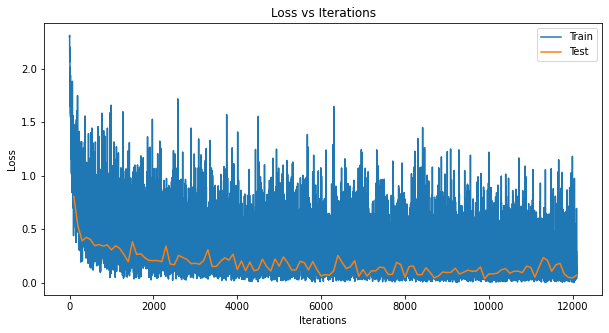

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_train)), losses_train, label='Train')
plt.plot(iterations, losses_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.show()


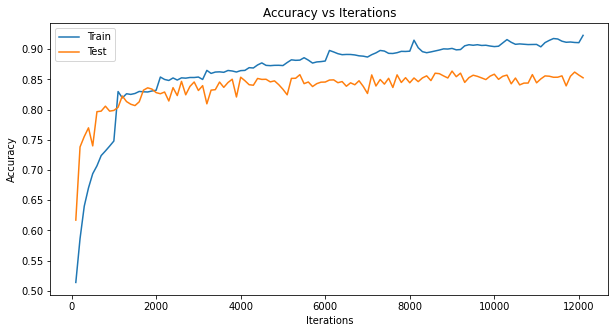

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracies_train, label='Train')
plt.plot(iterations, accuracies_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [35]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [36]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Dropout: 2-2                      [-1, 784]                 --
|    └─BatchNorm1d: 2-3                  [-1, 784]                 1,568
|    └─Linear: 2-4                       [-1, 128]                 100,480
|    └─ReLU: 2-5                         [-1, 128]                 --
|    └─BatchNorm1d: 2-6                  [-1, 128]                 256
|    └─Linear: 2-7                       [-1, 64]                  8,256
|    └─Tanh: 2-8                         [-1, 64]                  --
|    └─Linear: 2-9                       [-1, 10]                  650
Total params: 111,210
Trainable params: 111,210
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.44

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Dropout: 2-2                      [-1, 784]                 --
|    └─BatchNorm1d: 2-3                  [-1, 784]                 1,568
|    └─Linear: 2-4                       [-1, 128]                 100,480
|    └─ReLU: 2-5                         [-1, 128]                 --
|    └─BatchNorm1d: 2-6                  [-1, 128]                 256
|    └─Linear: 2-7                       [-1, 64]                  8,256
|    └─Tanh: 2-8                         [-1, 64]                  --
|    └─Linear: 2-9                       [-1, 10]                  650
Total params: 111,210
Trainable params: 111,210
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.44

In [37]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

iterations, losses_train, losses_test, accuracies_train, accuracies_test = train(model, train_loader, test_loader, loss_func, opt, epochs=10)


Epoch:  0 Iteration:  400 Loss:  0.3769150674343109 Accuracy train:  0.7812109375 Accuracy test:  0.8068359375
Epoch:  1 Iteration:  800 Loss:  0.3995424509048462 Accuracy train:  0.8234752643504532 Accuracy test:  0.82197265625
Epoch:  2 Iteration:  1200 Loss:  0.3936397433280945 Accuracy train:  0.837875715648855 Accuracy test:  0.83125
Epoch:  3 Iteration:  1600 Loss:  0.4514775276184082 Accuracy train:  0.8454501295336787 Accuracy test:  0.834375
Epoch:  4 Iteration:  2000 Loss:  0.3679253160953522 Accuracy train:  0.84765625 Accuracy test:  0.83564453125
Epoch:  5 Iteration:  2400 Loss:  0.49419423937797546 Accuracy train:  0.8602272727272727 Accuracy test:  0.83896484375
Epoch:  5 Iteration:  2800 Loss:  0.37338680028915405 Accuracy train:  0.8566964285714286 Accuracy test:  0.8478515625
Epoch:  6 Iteration:  3200 Loss:  0.3822745680809021 Accuracy train:  0.857755829015544 Accuracy test:  0.84521484375
Epoch:  7 Iteration:  3600 Loss:  0.4450961947441101 Accuracy train:  0.86215

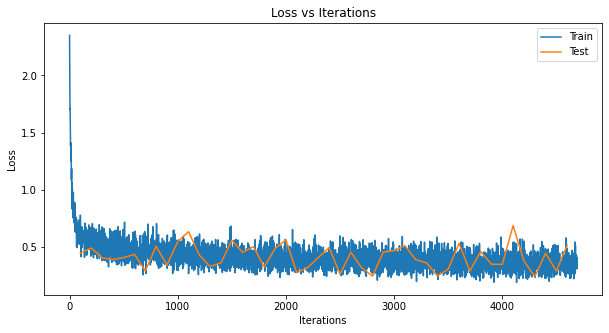

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_train)), losses_train, label='Train')
plt.plot(iterations, losses_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.show()


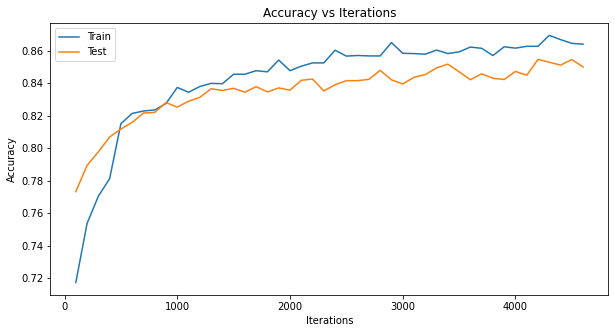

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracies_train, label='Train')
plt.plot(iterations, accuracies_test, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

The amount of epochs used to train a model definitely affects on the overfitting of the data.<br>

Also things like dropout and batchnorm really helped to get less overfitting, demonstrating how good these tools are to get a better model.

In the plots seen before is quite obvious that as the epochs go up, so does the accuracy for train data, meaning overfitting.<br>
In the fixed case, the accuracy stays about the same values, meaning we got close to some convergence point.
